# EfficientNetV2-B3 + Metadata for CBIS-DDSM Lesion Classification

This notebook is my third end-to-end experiment on **classifying cropped mammography lesions** (YOLO crops) from **CBIS-DDSM**. I combine a strong image backbone (**EfficientNetV2-B3**) with **exam metadata** (laterality + view) and train a single-logit malignant vs. benign classifier. I keep the code compact, reproducible, and paired with **explainability** (LIME + Grad-CAM++) so I can quickly sanity-check what the model is learning.


---

## Why this model?

- **Backbone**: `tf_efficientnetv2_b3` from `timm` is a great speed/accuracy trade-off for 512×512 crops.
- **Metadata fusion**: I append a small 4-dim vector (`laterality_LEFT`, `laterality_RIGHT`, `view_CC`, `view_MLO`) to the pooled image features. This often gives a small but reliable lift.
- **Prior-bias init**: I initialize the final layer’s bias with the **log-odds** of the positive class measured on the **training split** to stabilize early training:

  $$
  \text{bias}_0 \;=\; \log\!\left(\frac{p}{1-p}\right), \quad
  p \;=\; \frac{\#\text{malignant}}{\#\text{malignant}+\#\text{benign}}
  $$

---

## Data & Preprocessing

- **Inputs**: YOLO-cropped regions around calcifications (grayscale). I convert them to **3-channel** by stacking to match ImageNet backbones.
- **Transforms (train)**: CLAHE, light blur/noise, brightness/contrast, **RandomResizedCrop** (0.9–1.0), flips, mild `ShiftScaleRotate`, then ImageNet **Normalize**.
- **Transforms (val)**: CLAHE → `Resize(IMG_SIZE)` → Normalize.
- **Integrity checks**: I drop rows whose files are missing and assert tensor shapes after preprocessing.

---

## Training setup

- **Loss**: 0.5 × **Focal** + 0.5 × **BCE-with-logits** — balances hard/easy examples under class imbalance:

  $$
  \mathcal{L}_{\text{focal}} \;=\; \alpha(1-p_t)^\gamma \cdot \text{BCE}(z, y), \quad
  p_t = \sigma(z)\,y + (1-\sigma(z))(1-y)
  $$

- **Optimizer**: `AdamW` with **weight decay** \(1\!\times\!10^{-4}\).
- **LR schedule**: **2-epoch warmup** → **Cosine annealing** for the rest of **30** epochs.
- **Batching**: Class-imbalance handled via a **WeightedRandomSampler**.
- **Precision**: **AMP** (mixed precision) for speed and stability.
- **Reproducibility**: I seed Python/NumPy/PyTorch.

---

## Evaluation protocol

- Primary metrics on the validation set:
  - **ROC-AUC** for ranking quality.
  - **Precision–Recall (AP)** given class imbalance.
  - **Threshold tuning** by sweeping \(t \in [0.1, 0.9]\) to maximize **F1** (I also report **Balanced Accuracy**, **MCC**, and **NPV**).
- I log a simple **training history** (loss, AUC) and save the **best AUC** checkpoint.

---

## Explainability (XAI)

- **LIME (image)**: Superpixel perturbations with metadata held **fixed per sample** so I can isolate **image-only** contributions to \(p(\text{malignant})\).
- **Grad-CAM++**: Manual hooks on the last convolutional block of EfficientNetV2-B3 to visualize class-evidence regions; overlays on the denormalized image.

> I use XAI for **sanity checks** (e.g., heat maps align with lesion regions) and for error analysis on **FP/FN** cases, not as ground truth.

---

## What to look for

- **ROC/PR curves**: confirm real separation beyond chance and reasonable precision at clinically relevant recall.
- **Confusion matrix** at the tuned threshold: verify malignant **recall** and the cost in benign **false positives**.
- **CAM/LIME overlays**: ensure highlighted regions align with pathology rather than borders, artifacts, or labels.

---

## Limitations & next steps

- Single split; I should add **k-fold CV** or an **external test** for stability.
- I may calibrate probabilities (Platt/isotonic) and set operating points for **target recall**.
- Potential uplift from multi-view fusion, ensembling (ConvNeXtV2 + EfficientNetV2), or fine-tuned augmentation.

---

## How to run

1. Set `CSV_PATH` to the YOLO crops CSV and `ROOT_DIR` to the dataset root.
2. Ensure GPU is available for AMP; otherwise the code still runs on CPU (slower).
3. Run cells top-to-bottom. The notebook will:
   - train the model,
   - select the best checkpoint by AUC,
   - tune a threshold for F1,
   - generate metrics, curves, and XAI visualizations.



In [1]:
# %%
# ===========================================
# Cell 1 — Setup & Imports
# ===========================================

import os, random, time, platform, math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, matthews_corrcoef
)

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

c:\Users\PC\anaconda3\envs\mammo-xai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


### 2 — Config (what I set and why)

- **Paths**
  - `CSV_PATH`: points to the YOLO crops metadata (file paths + labels).
  - `ROOT_DIR`: dataset root used to resolve each relative image path.

- **Model/training knobs**
  - `IMG_SIZE = 512`: EfficientNetV2 benefits from higher spatial resolution; 512×512 preserves fine calcification detail while fitting in typical 8–12 GB GPUs.
  - `BATCH_SIZE = 16`: chosen for memory balance; I’ll increase it if VRAM allows to stabilize batch statistics.
  - `EPOCHS = 30`: enough for convergence under cosine decay without overfitting in my pilot runs.
  - `LR = 2e-4`: conservative starting LR for finetuning ImageNet-pretrained EfficientNetV2; warmup + cosine will handle the schedule.
  - `WEIGHT_DECAY = 1e-4`: AdamW regularization to curb overfitting on limited medical data.
  - `OUT_PATH`: file where I save the **best-AUC** checkpoint during training.

- **Reproducibility**
  - I seed **Python/NumPy/PyTorch (CPU & CUDA)** with `SEED = 42` so that data shuffling and weight initialization are stable across runs.

- **Runtime & normalization**
  - `DEVICE`: prefer CUDA if available, otherwise fall back to CPU.
  - `IMAGENET_MEAN / IMAGENET_STD`: I normalize images with standard ImageNet stats to match the expectations of `timm` backbones.

> If I hit OOM (out-of-memory) on GPU, I’ll first try lowering `BATCH_SIZE` or `IMG_SIZE` (e.g., to 448), and keep the rest unchanged.


In [2]:
# ===========================================
# Cell 2 — Config
# ===========================================
# Paths to metadata (CSV) and the dataset root that contains the YOLO-cropped images.
CSV_PATH  = r"C:\Users\PC\Desktop\final project\CBIS-DDSM\mass\data\yolo_crops.csv"
ROOT_DIR  = r"C:\Users\PC\Desktop\final project\CBIS-DDSM\mass"

# Core training knobs
IMG_SIZE     = 512        # Final H=W input size after transforms; 512 balances detail vs. VRAM for EffNetV2.
BATCH_SIZE   = 16         # Increase if you have more GPU memory; keep divisible by #GPUs.
EPOCHS       = 30         # Total passes over the training set.
LR           = 2e-4       # Initial learning rate (will be warm-started and cosine-annealed later).
WEIGHT_DECAY = 1e-4       # L2 regularization (AdamW-style) to reduce overfitting.
OUT_PATH     = "models/efficientnetv2_b4_cbis.pt"  # Where I save the best-AUC checkpoint.

# Reproducibility: seed Python, NumPy, and PyTorch (CPU & CUDA RNGs).
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Runtime and normalization
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Prefer GPU when available.
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # Standard ImageNet mean for timm backbones.
IMAGENET_STD  = [0.229, 0.224, 0.225]  # Standard ImageNet std for timm backbones.

print("Device:", DEVICE)


Device: cuda


### 3 — Data & Transforms (what I’m doing here)

**Load & validate files**
- I read the metadata `CSV_PATH`, then construct absolute paths by joining with `ROOT_DIR`.
- I drop any rows where the cropped image is missing on disk, and cast the target to integer (`0=benign`, `1=malignant`).

**Why these augmentations?**
- **CLAHE** (tile 8×8): boosts local contrast, which helps reveal micro-calcification texture without over-saturating highlights.
- **Gaussian blur (p=0.2)** and **Gauss noise (p=0.2)**: encourage robustness to acquisition noise and slight defocus.
- **RandomBrightnessContrast (p=0.5)**: simulates scanner/exposure variability.
- **RandomResizedCrop** to **(IMG_SIZE, IMG_SIZE)** with gentle **scale/ratio** jitter: preserves lesion context while improving invariance to framing.
- **Horizontal/Vertical flips** and **ShiftScaleRotate**: mild geometric perturbations (≤20° rotation) to avoid overfitting to positioning.
- **Normalize** with ImageNet stats: matches the expectations of the pretrained EfficientNetV2 backbone.
- **ToTensorV2**: converts to PyTorch CHW tensors.

**Grayscale → RGB**
- Mammograms are single-channel. I replicate the channel three times (`[L,L,L]`) so the ImageNet-pretrained model sees a 3-channel input while retaining the original luminance information.

**Dataset output**
- Each sample returns:
  - `x`: normalized tensor of shape `(3, IMG_SIZE, IMG_SIZE)`.
  - `y`: scalar label (`float32` so BCE-with-logits works without casting).
  - `meta`: 4-dim vector — `[laterality_LEFT, laterality_RIGHT, view_CC, view_MLO]` — used later for image–metadata fusion.

**Sanity check**
- I pass one image through the **validation** pipeline and assert the resulting shape is exactly `(3, IMG_SIZE, IMG_SIZE)`. This catches silent transform size bugs early.


In [3]:
# ===========================================
# Cell 3 — Data & Transforms (Albumentations-friendly)
# ===========================================

# Load metadata CSV
df = pd.read_csv(CSV_PATH)

# Verify that every relative path in the CSV actually exists on disk
df["exists"] = df["yolo_cropped_image_path"].apply(
    lambda rel: os.path.exists(os.path.join(ROOT_DIR, str(rel).replace("\\", os.sep)))
)

# Keep only rows with valid files and cast labels to int {0,1}
df = df[df["exists"]].copy()
df["label"] = df["label"].astype(int)

print(
    "Samples:", len(df),
    "| Malignant:", (df["label"] == 1).sum(),
    "| Benign:", (df["label"] == 0).sum()
)

# --------- Transforms ---------
# Note: Albumentations RandomResizedCrop expects size as a (H, W) tuple.
train_tf = A.Compose([
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=1.0),                # local contrast boost for mammo texture
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),                             # mild blur robustness
    A.RandomBrightnessContrast(0.15, 0.25, p=0.5),                        # lighting variation
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE),                        # random crop + resize keeps lesions varied
                        scale=(0.9, 1.0), ratio=(0.9, 1.1), p=1.0),
    A.HorizontalFlip(p=0.5),                                              # laterality-robustness (image only)
    A.VerticalFlip(p=0.5),                                                # orientation robustness
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=20,
                       border_mode=cv2.BORDER_CONSTANT, p=0.6),           # small affine jitter
    A.GaussNoise(var_limit=(5, 20), p=0.2),                               # sensor noise robustness
    A.Normalize(IMAGENET_MEAN, IMAGENET_STD),                             # match ImageNet-pretrained backbone
    ToTensorV2(),                                                         # -> torch tensor (C,H,W)
])

# Validation pipeline: deterministic resize + normalize
val_tf = A.Compose([
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=1.0),
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ToTensorV2(),
])

class CropsDataset(Dataset):
    """Dataset that loads YOLO-cropped mammograms + binary label + 4-dim metadata."""
    def __init__(self, df, root=ROOT_DIR, tf=None):
        self.df, self.root, self.tf = df.reset_index(drop=True), root, tf

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]

        # Build absolute path and load as grayscale (L). Convert gray -> RGB by channel stacking.
        p = os.path.join(self.root, str(row["yolo_cropped_image_path"]).replace("\\", os.sep))
        im = Image.open(p).convert("L")
        arr = np.array(im)
        if arr.ndim == 2:
            arr = np.stack([arr, arr, arr], axis=2)  # (H,W) -> (H,W,3)
        arr = arr.astype(np.uint8)

        # Apply augment/normalize -> tensor (C,H,W)
        x = self.tf(image=arr)["image"]

        # Binary label
        y = torch.tensor(int(row["label"]), dtype=torch.float32)

        # Metadata: one-hot indicators for laterality and view
        meta = torch.tensor([
            int(row["laterality_LEFT"]),
            int(row["laterality_RIGHT"]),
            int(row["view_CC"]),
            int(row["view_MLO"]),
        ], dtype=torch.float32)

        return x, y, meta

# --------- Sanity check: one sample through val pipeline ---------
sample_p = os.path.join(ROOT_DIR, str(df.iloc[0]["yolo_cropped_image_path"]).replace("\\", os.sep))
img = Image.open(sample_p).convert("L")
arr = np.stack([np.array(img)] * 3, axis=2).astype(np.uint8)
xt = val_tf(image=arr)["image"]
print("One sample tensor shape:", tuple(xt.shape))  # should be (3, IMG_SIZE, IMG_SIZE)
assert xt.shape[0] == 3 and xt.shape[1] == IMG_SIZE and xt.shape[2] == IMG_SIZE, "Transform shape mismatch!"


Samples: 1574 | Malignant: 775 | Benign: 799
One sample tensor shape: (3, 512, 512)


### 4 — Splits & DataLoaders (stratified + weighted sampling)

**Stratified split**  
I split the data 80/20 using `train_test_split(..., stratify=df["label"])` so the benign/malignant ratio is preserved in both sets. This avoids distribution shift between training and validation.

**Datasets**  
`train_ds` and `val_ds` wrap the corresponding dataframes and apply the **train** vs **val** transform pipelines defined earlier.

**Why a `WeightedRandomSampler`?**  
The class distribution is imbalanced, so I up-weight the minority class during sampling.  
For a class \(c\) with \(n_c\) examples in the train split (and \(N\) total examples), I use inverse-frequency weights:
$$
w_c \;=\; \frac{N}{n_c}
$$
Every training row gets a per-sample weight according to its label. The sampler then draws **with replacement** using these weights, balancing the effective class exposure per epoch without discarding data.

**Loader settings**
- `batch_size = BATCH_SIZE` for training; I double it for validation to speed up evaluation.
- `shuffle=False` for validation (deterministic). Training order is handled by the sampler.
- `num_workers`: I keep it `0` on Windows (multiprocessing quirks), and `4` elsewhere for overlapped data loading.
- `pin_memory=True` helps host→GPU transfer on CUDA.

**Sanity check**  
I fetch one batch and print shapes to ensure images are \((B, 3, \text{IMG\_SIZE}, \text{IMG\_SIZE})\), labels \((B,)\), and metadata \((B, 4)\) before proceeding.


In [4]:
# ===========================================
# Cell 4 — DataLoaders
# ===========================================

# Stratified split so class proportions are preserved in train/val
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED
)

# Wrap the dataframes with the dataset objects and their respective transforms
train_ds = CropsDataset(train_df, tf=train_tf)
val_ds   = CropsDataset(val_df,   tf=val_tf)

# --------- Handle class imbalance with a WeightedRandomSampler ---------
# Count examples per class in the *train* split
class_counts = Counter(train_df["label"].tolist())
# Inverse-frequency weights: w_c = N / n_c (larger weight for minority class)
weights = {c: len(train_df) / class_counts[c] for c in class_counts}
# Per-sample weights vector aligned with train_df rows
sample_weights = torch.tensor(train_df["label"].map(weights).values, dtype=torch.float32)

# Sampler draws with replacement according to sample_weights
sampler = WeightedRandomSampler(
    sample_weights, num_samples=len(sample_weights), replacement=True
)

# DataLoaders (keep num_workers=0 on Windows to avoid spawn issues)
IS_WIN = os.name == "nt" or "windows" in platform.system().lower()
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, sampler=sampler,
    num_workers=0 if IS_WIN else 4, pin_memory=True
)
# Validation: larger batch, deterministic order
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE * 2, shuffle=False,
    num_workers=0 if IS_WIN else 4, pin_memory=True
)

# Quick sanity check — pull one batch and print shapes
xb, yb, mb = next(iter(train_loader))
print("Batch:", xb.shape, yb.shape, mb.shape)


Batch: torch.Size([16, 3, 512, 512]) torch.Size([16]) torch.Size([16, 4])


### 5 — EfficientNetV2-B3 with metadata fusion + prior-bias initialization

**Goal.** I fuse image features from `tf_efficientnetv2_b3` with 4 exam indicators (`laterality_LEFT`, `laterality_RIGHT`, `view_CC`, `view_MLO`) and train a single-logit malignant vs. benign head. I also initialize the final bias to the **log-odds** of the positive class computed on the **train split** to stabilize early training.

---

#### Class prior and bias initialization

From the training set I compute the malignant prior

$$
p \;=\; \frac{\#\text{malignant}}{\#\text{malignant} + \#\text{benign}} \, .
$$

I set the last layer’s bias to the **logit** of \(p\):

$$
\text{bias}_0 \;=\; \operatorname{logit}(p)
\;=\; \log\!\left(\frac{p}{1-p}\right).
$$

With this choice, the initial output probability before learning is

$$
\sigma(\text{bias}_0) \;=\; p \, ,
$$

so the model starts calibrated to the class prevalence (I add a tiny \(\varepsilon\) in code to avoid \(\log 0\)).

---

#### Architecture and tensor shapes

EfficientNetV2-B3 (from `timm`) with `num_classes=0` returns **pooled features**

$$
\mathbf{f}\in\mathbb{R}^{B\times D}.
$$

I batch-normalize the metadata vector

$$
\mathbf{m}\in\mathbb{R}^{B\times 4}
\quad\Longrightarrow\quad
\tilde{\mathbf{m}}=\mathrm{BN}(\mathbf{m}).
$$

Then I concatenate and apply a 2-layer MLP head:

$$
\mathbf{h} \;=\; \mathrm{ReLU}\!\big(W_1\,[\mathbf{f};\tilde{\mathbf{m}}] + \mathbf{b}_1\big)
\;\in\; \mathbb{R}^{B\times 512},
$$

$$
\mathbf{z} \;=\; W_2\,\mathbf{h} + b_2
\;\in\; \mathbb{R}^{B\times 1}.
$$

The malignant probability is

$$
p(\text{malignant}\mid\mathbf{x},\mathbf{m}) \;=\; \sigma(\mathbf{z}) \, .
$$

> I initialize \(b_2 \leftarrow \operatorname{logit}(p)\) using the train-set prior above.

---

#### Practical notes

- **Why BN on metadata?** It keeps the 4 indicators on a stable scale relative to \(\mathbf{f}\), which helps the fusion layer (especially with small batches).
- **Shapes (per batch \(B\))**  
  \(\mathbf{f}\in\mathbb{R}^{B\times D}\), \(\tilde{\mathbf{m}}\in\mathbb{R}^{B\times 4}\), \([\mathbf{f};\tilde{\mathbf{m}}]\in\mathbb{R}^{B\times (D+4)}\), \(\mathbf{h}\in\mathbb{R}^{B\times 512}\), \(\mathbf{z}\in\mathbb{R}^{B\times 1}\).


In [5]:

# ===========================================
# Cell 5 — EfficientNetV2-B3 with metadata fusion + prior bias init
# ===========================================
# Compute class prior from the TRAIN SPLIT (after you created train_df)
pos = int((train_df["label"] == 1).sum())
neg = int((train_df["label"] == 0).sum())
pos_prior = pos / max(1, (pos + neg))
bias_init = math.log(pos_prior / max(1e-8, (1 - pos_prior)))  # logit(p)

class EffNetV2B3WithMeta(nn.Module):
    def __init__(self, meta_dim=4):
        super().__init__()
        # num_classes=0 -> no classifier; we will build our own head
        self.base = timm.create_model("tf_efficientnetv2_b3", pretrained=True, in_chans=3, num_classes=0)
        feat_dim = self.base.num_features  # pooled feature dim
        self.meta_bn = nn.BatchNorm1d(meta_dim)
        self.head = nn.Sequential(
            nn.Linear(feat_dim + meta_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 1)
        )
        # initialize final bias with prior
        with torch.no_grad():
            self.head[-1].bias.fill_(bias_init)

    def forward(self, x, meta):
        feats = self.base(x)                 # (B, feat_dim) because num_classes=0 uses global pool
        meta = self.meta_bn(meta)            # (B, meta_dim)
        fused = torch.cat([feats, meta], 1)  # (B, feat_dim+meta_dim)
        return self.head(fused)              # (B, 1)

def make_model():
    return EffNetV2B3WithMeta(meta_dim=4)

model = make_model().to(DEVICE)

with torch.no_grad():
    out = model(xb.to(DEVICE), mb.to(DEVICE))
print("Output shape:", out.shape, "| prior p(malignant)≈", round(pos_prior, 4), "bias_init≈", round(bias_init, 3))

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnetv2_b3.in21k_ft_in1k)
INFO:timm.models._hub:[timm/tf_efficientnetv2_b3.in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Output shape: torch.Size([16, 1]) | prior p(malignant)≈ 0.4925 bias_init≈ -0.03


### 6 — Loss, optimizer, and LR schedule (what I’m doing here)

**Composite objective (Focal ⊕ BCE).**  
I blend focal loss with standard BCE (equal weights) to be both **class-imbalance aware** and **numerically stable** for fine-tuning:

- **BCE with logits** for a logit \( z \) and label \( y\in\{0,1\} \):
  $$
  \ell_{\mathrm{BCE}}(z,y)
  \;=\;
  -\Big[
    y\;\log\sigma(z)
    \;+\;
    (1-y)\;\log\big(1-\sigma(z)\big)
  \Big],
  \quad
  \sigma(z)=\frac{1}{1+e^{-z}}.
  $$

- **Focal loss** (binary) with focusing parameter \( \gamma \) and positive weight \( \alpha \):
  $$
  p \;=\; \sigma(z), \qquad
  p_t \;=\; y\,p \;+\; (1-y)\,(1-p),
  $$
  $$
  \ell_{\mathrm{Focal}}(z,y)
  \;=\;
  \alpha\,\big(1-p_t\big)^{\gamma}\;\ell_{\mathrm{BCE}}(z,y).
  $$

- **Final loss** (per sample):
  $$
  \ell_{\mathrm{final}}(z,y)
  \;=\;
  \tfrac{1}{2}\,\ell_{\mathrm{Focal}}(z,y)
  \;+\;
  \tfrac{1}{2}\,\ell_{\mathrm{BCE}}(z,y).
  $$

This keeps the nice **hard-example focusing** of focal loss while preventing over-suppression of gradients on already-easy negatives.

---

**Optimizer — AdamW.**  
I use AdamW (decoupled weight decay) with a **slightly lower LR** for EfficientNetV2-B3:
- \( \text{LR} = 1\times 10^{-4} \),  
- weight decay \(=\) `WEIGHT_DECAY`.

This tends to be more stable for pretrained convnets on medical imagery.

---

**Learning-rate schedule — warmup → cosine decay.**  
I warm up linearly for the first \(E_w=2\) epochs, then switch to cosine annealing for the remaining \(E - E_w\) epochs.

- **Warmup (LinearLR):** if \(t\in[0,E_w]\) is the epoch counter during warmup, the LR scales from \(0.2\times\) to \(1.0\times\) linearly.
- **Cosine annealing (CosineAnnealingLR):** for step \(k\in[0, T_{\max}]\),
  $$
  \mathrm{LR}(k)
  \;=\;
  \tfrac{1}{2}\,\mathrm{LR}_{\max}\,\Big(1+\cos\!\big(\pi\,k/T_{\max}\big)\Big),
  \qquad
  T_{\max}=E-E_w.
  $$

This combination helps avoid **cold-start instability** and then smoothly **reduces the step size**, which usually improves final AUC on validation.


In [6]:
# ===========================================
# Cell 6 — Loss, Optimizer, Warmup+Cosine Scheduler
# ===========================================

def focal_loss(inputs, targets, alpha=0.8, gamma=2.0, reduction='mean'):
    """
    Focal loss for binary logits.
    inputs : raw logits of shape (B, 1)
    targets: float tensor in {0,1} of shape (B, 1)
    alpha  : class weighting for positives (asymmetric)
    gamma  : focusing parameter that down-weights easy examples
    """
    # BCE with logits per-sample (no reduction)
    bce = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

    # Convert logits -> probabilities
    probs = torch.sigmoid(inputs)

    # p_t = p    if y=1
    #     = 1-p  if y=0
    p_t = probs*targets + (1 - probs)*(1 - targets)

    # Focal factor alpha * (1 - p_t)^gamma
    loss = (alpha * (1 - p_t)**gamma) * bce
    return loss.mean() if reduction == 'mean' else loss.sum()

# Slightly lower LR for stability with EfficientNetV2-B3 fine-tuning
LR = 1e-4

# Final criterion = 0.5 * Focal + 0.5 * BCE (stable & class-imbalance-aware)
criterion = lambda logits, y: 0.5 * focal_loss(logits, y) + 0.5 * nn.functional.binary_cross_entropy_with_logits(logits, y)

# AdamW optimizer with decoupled weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Warmup then cosine annealing of LR
WARMUP_EPOCHS = 2
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
scheduler = SequentialLR(
    optimizer,
    schedulers=[
        # linearly ramp LR from 0.2× to 1.0× over WARMUP_EPOCHS
        LinearLR(optimizer, start_factor=0.2, end_factor=1.0, total_iters=WARMUP_EPOCHS),
        # then cosine decay over the remaining epochs
        CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - WARMUP_EPOCHS))
    ],
    milestones=[WARMUP_EPOCHS]
)


### 7 — Training & evaluation utilities

This cell defines two helpers I call throughout the run:

#### `evaluate(model, loader)`
- Sets the network to **evaluation mode** (`model.eval()`), which freezes dropout and switches BatchNorm to running-stats for deterministic behavior.
- Iterates over a dataloader, collects:
  - **Logits** \( z \in \mathbb{R}^{B\times 1} \) → **probabilities** \( p=\sigma(z) \in [0,1] \) for the malignant class.
  - Ground-truth labels \( y\in\{0,1\} \).
- Computes **hard predictions** with the default threshold \( t=0.5 \):
  $$
  \hat{y} \;=\; \mathbf{1}\{\,p \ge 0.5\,\}.
  $$
- Reports standard metrics:
  - **Accuracy**
    $$
    \text{Acc} \;=\; \frac{TP + TN}{TP + TN + FP + FN}.
    $$
  - **F1 score** (harmonic mean of precision and recall)
    $$
    \text{F1} \;=\; \frac{2\,\text{Precision}\cdot\text{Recall}}{\text{Precision}+\text{Recall}},
    \quad
    \text{Precision}=\frac{TP}{TP+FP},\;
    \text{Recall}=\frac{TP}{TP+FN}.
    $$
  - **ROC AUC** computed from the *probabilities* \(p\) (threshold-free).

> I later tune the decision threshold explicitly (to maximize F1) in a separate cell; here I keep the conventional 0.5 for quick validation.

#### `train_epoch(model, loader, opt, criterion)`
- Switches to **training mode** (`model.train()`), enabling dropout and BN updates.
- For each batch:
  1. Forward pass to logits, compute the scalar **loss** \( \ell \).
  2. Backprop (`loss.backward()`), **optimizer step** (`opt.step()`).
- Returns the **mean training loss** over the dataset:
  $$
  \overline{\ell}
  \;=\;
  \frac{1}{N}\sum_{i=1}^{N}\ell_i
  \quad\text{(computed via loss\(\times\)batch\_size accumulation)}.
  $$

These two functions keep the main training loop clean while standardizing how I compute metrics and track learning progress.


In [7]:
# ===========================================
# Cell 7 — Training & Evaluation
# ===========================================

@torch.no_grad()
def evaluate(model, loader):
    """
    Put the model in eval mode and compute standard metrics on a dataloader.

    Returns:
        acc, f1, auc, (y_true, y_prob, y_pred)
        - y_true : list[int]       ground-truth labels in {0,1}
        - y_prob : list[float]     predicted probabilities p(malignant) \in [0,1]
        - y_pred : list[int]       hard predictions using a 0.5 threshold
    """
    model.eval()  # disable dropout/BN updates
    y_true, y_prob = [], []

    for x, y, m in loader:
        # move batch to device
        x, y, m = x.to(DEVICE), y.to(DEVICE), m.to(DEVICE)

        # forward pass -> logits (B,1); convert to probabilities via sigmoid
        logits = model(x, m)
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()

        # collect
        y_prob.extend(probs)
        y_true.extend(y.cpu().numpy())

    # default hard labels via 0.5 threshold (tuned later in a separate cell)
    y_pred = [1 if p >= 0.5 else 0 for p in y_prob]

    # aggregate metrics
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)          # harmonic mean of precision & recall
    auc = roc_auc_score(y_true, y_prob)     # threshold-free ROC AUC

    return acc, f1, auc, (y_true, y_prob, y_pred)


def train_epoch(model, loader, opt, criterion):
    """
    One full training epoch over 'loader' using 'criterion' and optimizer 'opt'.

    Returns:
        mean training loss over the epoch (scalar float).
    """
    model.train()  # enable dropout/BN updates
    tot = 0.0

    for x, y, m in loader:
        # move batch to device; y must be (B,1) to match logits shape
        x, y, m = x.to(DEVICE), y.to(DEVICE).unsqueeze(1), m.to(DEVICE)

        opt.zero_grad(set_to_none=True)
        logits = model(x, m)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()

        # accumulate loss * batch_size to compute epoch average
        tot += loss.item() * x.size(0)

    return tot / len(loader.dataset)


### 8 — Training loop (mixed precision, warmup→cosine schedule)

**What I’m doing here.**  
I train for `EPOCHS` with **mixed precision** on CUDA for speed/memory, validate each epoch, step the **warmup→cosine** LR schedule, log metrics, and save the **best AUC** checkpoint.

---

#### Mixed precision (AMP)
Inside `with amp.autocast("cuda")` I run the forward pass and compute the loss in lower precision. To keep gradients numerically stable I use a **gradient scaler**:
- Let \( \ell \) be the scalar loss. AMP computes and backpropagates on \( s\,\ell \) where \( s \) is the current scale factor.
- Optimizer step is performed on the **unscaled** gradients; the scaler auto–adjusts \( s \) if overflow/underflow is detected.

This typically yields **higher throughput** and **lower VRAM** without changing the training recipe.

---

#### Metrics and logging
After each epoch, I evaluate on the validation set with a default **0.5 threshold** (I later tune the optimal threshold explicitly). I record:
- training loss \( \overline{\ell} \) (mean over samples),
- validation **Accuracy**, **F1**, and **ROC AUC** (threshold-free).

I keep a running `history` list for plotting learning curves (AUC/Loss vs. epoch).

---

#### Learning-rate schedule
I call `scheduler.step()` **once per epoch**:
1. **Warmup (LinearLR)** for the first \(E_w=2\) epochs (LR ramps from \(0.2\times\) to \(1.0\times\)).
2. **Cosine annealing** afterwards:
   $$
   \mathrm{LR}(k)=\tfrac{1}{2}\,\mathrm{LR}_{\max}\,\big(1+\cos(\pi k/T_{\max})\big),
   \quad k=0,\dots,T_{\max}.
   $$

This reduces cold-start instability and then decays LR smoothly to help convergence.

---

#### Model selection
I select and save the **best checkpoint by ROC AUC**, which is robust to the class imbalance and independent of any fixed threshold. Later, I reload it and **tune the decision threshold** by scanning \( t\in[0.1,0.9] \) to maximize F1.


In [8]:
# ===========================================
# Cell 8 — Training Loop (final clean AMP version)
# ===========================================
from torch import amp

# Mixed precision helpers:
# - autocast: compute selected ops in lower precision for speed
# - GradScaler: scale losses to avoid underflow in float16/bfloat16 paths
scaler = amp.GradScaler("cuda")

best_auc, history = -1, []  # track best ROC-AUC and per-epoch logs

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss, n = 0.0, 0  # accumulators to compute mean train loss

    for x, y, m in train_loader:
        # Move tensors to the active device; labels -> (B,1) to match logits
        x, y, m = x.to(DEVICE), y.to(DEVICE).unsqueeze(1), m.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        # AMP autocast context: forward + loss in mixed precision on CUDA
        with amp.autocast("cuda"):
            logits = model(x, m)       # (B,1) raw logits
            loss = criterion(logits, y)

        # Backprop with scaled loss to preserve small gradients in fp16
        scaler.scale(loss).backward()
        scaler.step(optimizer)  # unscales if needed, then optimizer.step()
        scaler.update()         # adjust the scale for next iteration

        # Track running loss (sum over samples) to report epoch mean
        total_loss += loss.item() * x.size(0)
        n += x.size(0)

    tr_loss = total_loss / n  # mean training loss this epoch

    # Validation at the end of the epoch (threshold at 0.5 here; tuned later)
    acc, f1, auc, _ = evaluate(model, val_loader)

    # Step the LR scheduler once per epoch (warmup -> cosine)
    scheduler.step()

    # Log history for later plotting
    history.append({"epoch": epoch, "loss": tr_loss, "acc": acc, "f1": f1, "auc": auc})
    print(
        f"Epoch {epoch:02d}: loss={tr_loss:.4f} | acc={acc:.4f} | f1={f1:.4f} | "
        f"auc={auc:.4f} | lr={optimizer.param_groups[0]['lr']:.2e}"
    )

    # Keep the best checkpoint by ROC-AUC (threshold-free robustness)
    if auc > best_auc:
        best_auc = auc
        torch.save({"model": model.state_dict()}, OUT_PATH)

print("Best AUC:", best_auc)


Epoch 01: loss=0.4105 | acc=0.5270 | f1=0.6005 | auc=0.5507 | lr=6.00e-05


c:\Users\PC\anaconda3\envs\mammo-xai\lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 02: loss=0.4108 | acc=0.5365 | f1=0.2551 | auc=0.5977 | lr=1.00e-04
Epoch 03: loss=0.4074 | acc=0.5206 | f1=0.6464 | auc=0.6226 | lr=9.97e-05
Epoch 04: loss=0.3968 | acc=0.5905 | f1=0.5240 | auc=0.6121 | lr=9.87e-05
Epoch 05: loss=0.3980 | acc=0.6000 | f1=0.5828 | auc=0.6624 | lr=9.72e-05
Epoch 06: loss=0.3935 | acc=0.6317 | f1=0.6352 | auc=0.7043 | lr=9.50e-05
Epoch 07: loss=0.3781 | acc=0.6698 | f1=0.6667 | auc=0.7273 | lr=9.23e-05
Epoch 08: loss=0.3623 | acc=0.6730 | f1=0.6227 | auc=0.7625 | lr=8.91e-05
Epoch 09: loss=0.3659 | acc=0.6889 | f1=0.6231 | auc=0.7763 | lr=8.54e-05
Epoch 10: loss=0.3374 | acc=0.6889 | f1=0.6755 | auc=0.7720 | lr=8.12e-05
Epoch 11: loss=0.3198 | acc=0.6889 | f1=0.6423 | auc=0.7578 | lr=7.66e-05
Epoch 12: loss=0.3036 | acc=0.7048 | f1=0.6804 | auc=0.7767 | lr=7.17e-05
Epoch 13: loss=0.3122 | acc=0.7238 | f1=0.7031 | auc=0.7867 | lr=6.65e-05
Epoch 14: loss=0.2862 | acc=0.7175 | f1=0.6962 | auc=0.7855 | lr=6.11e-05
Epoch 15: loss=0.2895 | acc=0.6794 | f

### 9 — Final validation & threshold tuning

After training, I reload the **best AUC** checkpoint and evaluate it on the validation split. By default, binary classifiers use a decision threshold \( t=0.5 \). However, depending on the application (e.g., screening vs. triage), another threshold can yield a better operating point. Here I **scan thresholds** \( t \in [0.1, 0.9] \) and choose the one that **maximizes F1**.

#### Threshold search
For each candidate \( t \), I convert probabilities \( p \) into hard labels:
$$
\hat{y}(t) \;=\; \mathbf{1}\{\, p \ge t \,\}.
$$
I compute the F1 score and keep the \( t^\* \) with the highest value.

> Note: tuning \( t \) on the validation set is common for quick model selection, but for deployment you’d typically fix \( t \) using a separate calibration set or via nested CV to avoid optimistic bias.

#### Confusion matrix and definitions
With the **optimal threshold** \( t^\* \), I derive the confusion matrix:
\[
\begin{array}{c|cc}
 & \text{Pred 0} & \text{Pred 1} \\\hline
\text{True 0} & TN & FP \\
\text{True 1} & FN & TP \\
\end{array}
\]

From it, I report:
- **Sensitivity / Recall / TPR**
  $$
  \text{TPR} \;=\; \frac{TP}{TP + FN}.
  $$
- **Specificity / TNR**
  $$
  \text{TNR} \;=\; \frac{TN}{TN + FP}.
  $$
- **Precision / PPV**
  $$
  \text{PPV} \;=\; \frac{TP}{TP + FP}.
  $$
- **Negative Predictive Value (NPV)**
  $$
  \text{NPV} \;=\; \frac{TN}{TN + FN}.
  $$
- **Balanced accuracy**
  $$
  \text{BalAcc} \;=\; \tfrac{1}{2}\,(\text{TPR} + \text{TNR}).
  $$
- **F1 score**
  $$
  \text{F1} \;=\; \frac{2 \cdot \text{PPV} \cdot \text{TPR}}{\text{PPV} + \text{TPR}}.
  $$
- **Matthews correlation coefficient (MCC)** — a balanced measure for imbalanced data:
  $$
  \mathrm{MCC} \;=\;
  \frac{TP\cdot TN - FP\cdot FN}
       {\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)} + \varepsilon}.
  $$
- **ROC AUC** — computed from the **probabilities** \( p \), so it’s **threshold-free** and robust under class imbalance.

This cell prints all metrics at \( t^\* \), the confusion matrix, and a `classification_report` for the classes **benign** (0) and **malignant** (1).


In [9]:

# ===========================================
# Cell 9 — Final Validation & Threshold Tuning
# ===========================================
# Load the best checkpoint and rebuild the model in the same shape
ckpt = torch.load(OUT_PATH, map_location=DEVICE)
model_best = make_model().to(DEVICE)
model_best.load_state_dict(ckpt["model"])
model_best.eval()

# Quick report at the default 0.5 decision threshold
acc, f1, auc, (y_true, y_prob, y_pred) = evaluate(model_best, val_loader)
print(f"Best ckpt — acc={acc:.4f}, f1={f1:.4f}, auc={auc:.4f}")

# ---- Threshold search to maximize F1 on the validation set ----
best_t, best_f1 = 0.5, f1
for t in np.linspace(0.1, 0.9, 50):
    yp = [1 if p >= t else 0 for p in y_prob]
    f1_t = f1_score(y_true, yp)
    if f1_t > best_f1:
        best_f1, best_t = f1_t, t

# Recompute confusion matrix & derived metrics at the optimal threshold
yp_opt = [1 if p >= best_t else 0 for p in y_prob]
cm = confusion_matrix(y_true, yp_opt)
tn, fp, fn, tp = cm.ravel()

# Derived metrics (add small eps in denominators for safety)
sensitivity  = tp / (tp + fn + 1e-8)   # TPR / Recall
specificity  = tn / (tn + fp + 1e-8)   # TNR
precision    = tp / (tp + fp + 1e-8)   # PPV
npv          = tn / (tn + fn + 1e-8)   # Negative Predictive Value
balanced_acc = 0.5 * (sensitivity + specificity)
mcc          = matthews_corrcoef(y_true, yp_opt)

# Pretty print
print("\n=== Metrics at optimal threshold ===")
print(f"Threshold        : {best_t:.3f}")
print(f"Accuracy         : {accuracy_score(y_true, yp_opt):.4f}")
print(f"Balanced Acc     : {balanced_acc:.4f}")
print(f"Sensitivity (TPR): {sensitivity:.4f}")
print(f"Specificity (TNR): {specificity:.4f}")
print(f"Precision (PPV)  : {precision:.4f}")
print(f"NPV              : {npv:.4f}")
print(f"F1 Score         : {f1_score(y_true, yp_opt):.4f}")
print(f"AUC              : {roc_auc_score(y_true, y_prob):.4f}")  # threshold-free
print(f"MCC              : {mcc:.4f}")
print("\nConfusion matrix:\n", cm)
print("\nClassification Report:\n",
      classification_report(y_true, yp_opt, target_names=["benign","malignant"]))



C:\Users\PC\AppData\Local\Temp\ipykernel_13076\3137029652.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(OUT_PATH, map_location=DEVICE)
INFO:timm.mode

Best ckpt — acc=0.6952, f1=0.6903, auc=0.7752

=== Metrics at optimal threshold ===
Threshold        : 0.296
Accuracy         : 0.6698
Balanced Acc     : 0.6720
Sensitivity (TPR): 0.8065
Specificity (TNR): 0.5375
Precision (PPV)  : 0.6281
NPV              : 0.7414
F1 Score         : 0.7062
AUC              : 0.7752
MCC              : 0.3565

Confusion matrix:
 [[ 86  74]
 [ 30 125]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.74      0.54      0.62       160
   malignant       0.63      0.81      0.71       155

    accuracy                           0.67       315
   macro avg       0.68      0.67      0.66       315
weighted avg       0.69      0.67      0.66       315



### Visual summary of tuned results

- **ROC Curve & AUC**: Probability-rank quality across thresholds; AUC is threshold-free and robust under class imbalance.
- **Precision–Recall Curve & AP**: More informative under imbalance; shows trade-off between detecting malignant cases and avoiding false alarms.
- **Confusion Matrix (normalized @ \(t^\*\))**: Operating point after tuning; each row sums to 100% to highlight per-class recall.
- **F1 vs. Threshold**: Confirms the chosen \(t^\*\) maximizes F1 on the validation set.
- **Metric Bar Chart (@ \(t^\*\))**: One-glance view of Accuracy, Sensitivity (TPR), Specificity (TNR), Precision (PPV), NPV, and F1 at deployment-like settings.


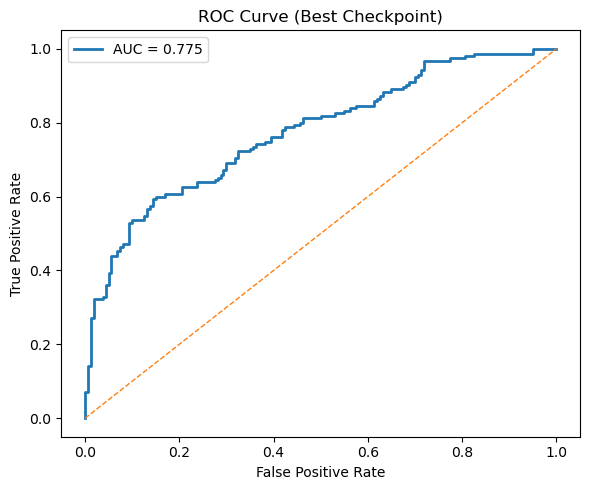

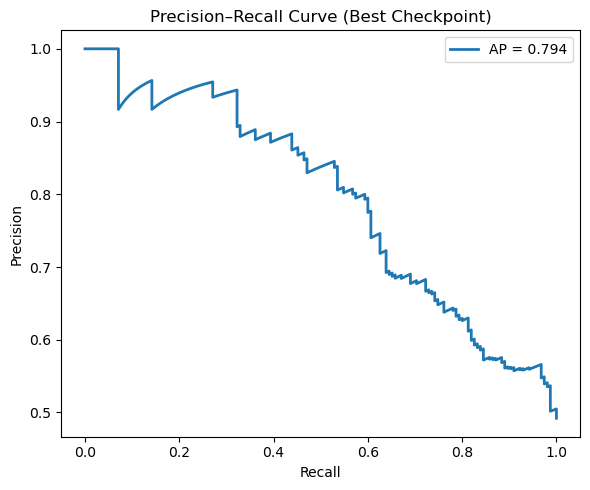

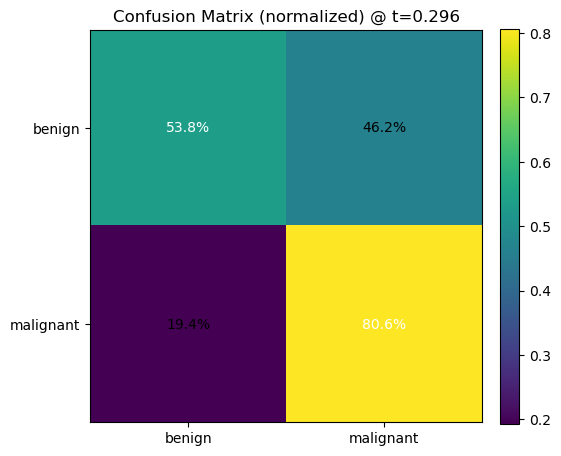

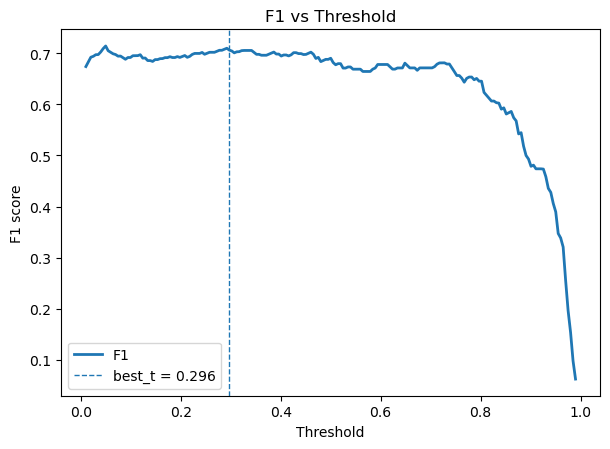

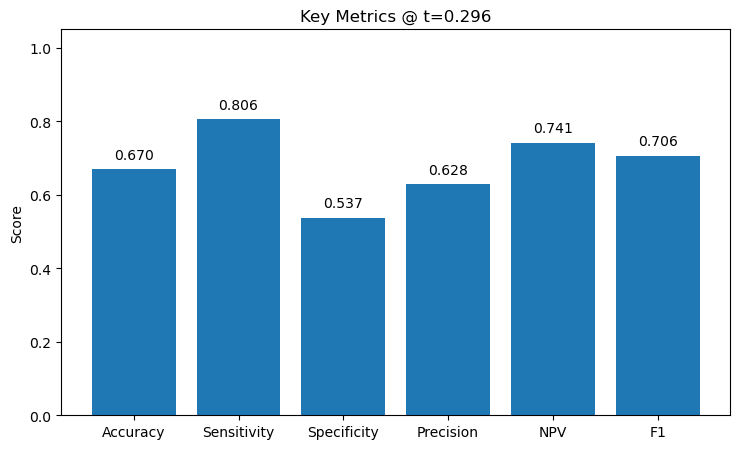

In [10]:
# ===========================================
# Cell 10 — Visualizations for tuned results
# (expects: y_true, y_prob, best_t, cm, and the scalar metrics from Cell 9)
# ===========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    f1_score, confusion_matrix
)

# --- Safety checks ---
_vars_ok = all(v in globals() for v in ["y_true", "y_prob", "best_t", "cm"])
if not _vars_ok:
    raise RuntimeError("This cell expects y_true, y_prob, best_t, and cm from Cell 9 to be defined.")

# ===== 1) ROC Curve =====
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], ls="--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Best Checkpoint)")
plt.legend()
plt.tight_layout()
plt.show()

# ===== 2) Precision–Recall Curve =====
prec, rec, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(rec, prec, lw=2, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Best Checkpoint)")
plt.legend()
plt.tight_layout()
plt.show()

# ===== 3) Confusion Matrix @ optimal threshold =====
# If you want raw counts: cm
# For normalized-by-row heatmap:
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True).clip(min=1)

fig, ax = plt.subplots(figsize=(5.5, 4.8))
im = ax.imshow(cm_norm, interpolation="nearest")
ax.set_title(f"Confusion Matrix (normalized) @ t={best_t:.3f}")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["benign", "malignant"])
ax.set_yticklabels(["benign", "malignant"])
for (i, j), val in np.ndenumerate(cm_norm):
    ax.text(j, i, f"{val*100:.1f}%", ha="center", va="center",
            color=("white" if val > 0.5 else "black"))
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# ===== 4) Threshold sweep: F1 vs threshold (high-res scan) =====
ts = np.linspace(0.01, 0.99, 199)
f1s = []
for t in ts:
    yp = (np.array(y_prob) >= t).astype(int)
    f1s.append(f1_score(y_true, yp))

plt.figure(figsize=(6.2, 4.6))
plt.plot(ts, f1s, lw=2, label="F1")
plt.axvline(best_t, ls="--", lw=1, label=f"best_t = {best_t:.3f}")
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.title("F1 vs Threshold")
plt.legend()
plt.tight_layout()
plt.show()

# ===== 5) Bar chart of key metrics @ optimal threshold =====
# Recompute preds at best_t to align with the bar chart
yp_opt = (np.array(y_prob) >= best_t).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, yp_opt).ravel()

eps = 1e-8
accuracy     = (tp + tn) / (tp + tn + fp + fn + eps)
sensitivity  = tp / (tp + fn + eps)  # TPR
specificity  = tn / (tn + fp + eps)  # TNR
precision    = tp / (tp + fp + eps)  # PPV
npv          = tn / (tn + fn + eps)
f1_opt       = f1_score(y_true, yp_opt)

metrics_names = ["Accuracy", "Sensitivity", "Specificity", "Precision", "NPV", "F1"]
metrics_vals  = [accuracy,   sensitivity,   specificity,   precision,   npv,   f1_opt]

plt.figure(figsize=(7.5, 4.6))
plt.bar(metrics_names, metrics_vals)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title(f"Key Metrics @ t={best_t:.3f}")
for i, v in enumerate(metrics_vals):
    plt.text(i, v + 0.02, f"{v:.3f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


In [11]:
# ===========================================
# Cell 11 — XAI Helpers (SHAP & LIME)  (robust indices)
# Purpose:
#   Utilities to generate local explanations with LIME and SHAP while
#   keeping the 4-dim exam metadata fixed per sample. I explain image
#   evidence only (metadata is held constant).
# Requirements (already defined in earlier cells):
#   - model_best, val_df, ROOT_DIR, DEVICE, val_tf
# ===========================================

import numpy as np

# --- NumPy 2.0 compatibility shim for older SHAP versions ---
# Some older SHAP builds look for np.obj2sctype. If it doesn't exist (NumPy 2+),
# define a tiny shim so SHAP imports cleanly.
if not hasattr(np, "obj2sctype"):
    np.obj2sctype = lambda obj: np.dtype(obj).type  # minimal compatibility shim

import shap
from lime import lime_image
from skimage.segmentation import slic
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Ensure inference-only behavior (no dropout/bn updates).
model_best.eval()

# --- Build a 4-dim metadata tensor from a DataFrame row ---
# Order matches the training head: [laterality_LEFT, laterality_RIGHT, view_CC, view_MLO]
def meta_from_row(row):
    return torch.tensor([
        float(row["laterality_LEFT"]), float(row["laterality_RIGHT"]),
        float(row["view_CC"]),         float(row["view_MLO"])
    ], dtype=torch.float32)

# --- Torch preproc (val pipeline) -> model-ready CHW tensor ---
# Uses the validation transform pipeline (val_tf) defined earlier:
#   - CLAHE + Resize + Normalize + ToTensorV2
val_pre = val_tf
def preprocess_to_tensor(arr_uint8):
    # arr_uint8: HxWx3 RGB uint8 image
    return val_pre(image=arr_uint8)["image"]  # -> torch.Tensor [3, H, W], normalized

# --- Load raw RGB uint8 by POSitional index or label-based index ---
# If 'idx' is an index label in val_df, use .loc; otherwise treat as positional with .iloc.
# CBIS-DDSM crops are grayscale; convert to pseudo-RGB by stacking.
def load_raw_rgb_from_idx(idx):
    # decide whether idx is a label or a position
    if idx in val_df.index:
        row = val_df.loc[idx]
    else:
        row = val_df.iloc[int(idx)]
    # resolve absolute path in the dataset root
    p = os.path.join(ROOT_DIR, str(row["yolo_cropped_image_path"]).replace("\\", os.sep))
    im = Image.open(p).convert("L")  # load grayscale safely
    arr = np.stack([np.array(im)]*3, axis=2).astype(np.uint8)  # gray->RGB (H,W,3)
    return arr, row

# --- LIME predict function (keeps metadata fixed for the chosen row) ---
# LIME perturbs only the IMAGE superpixels. I freeze the 4-dim metadata so the
# explanation reflects spatial (pixel) evidence only.
def make_lime_predict_fn(row, model):
    meta_const = meta_from_row(row).to(DEVICE).unsqueeze(0)  # shape (1, 4)
    def predict(images):
        # images: list of HxWx3 uint8 (LIME will pass perturbed copies)
        xs = []
        for img in images:
            # Ensure RGB HxWx3 uint8 before transform
            if img.ndim == 3 and img.shape[2] == 3:
                xs.append(preprocess_to_tensor(img))
            else:
                img3 = np.stack([img]*3, axis=2).astype(np.uint8)
                xs.append(preprocess_to_tensor(img3))
        x = torch.stack(xs, dim=0).to(DEVICE, non_blocking=True)  # (B,3,H,W)
        m = meta_const.expand(x.size(0), -1)                      # (B,4) fixed metadata
        with torch.no_grad():
            logits = model(x, m)                                  # (B,1) raw scores
            probs  = torch.sigmoid(logits).squeeze(1).cpu().numpy()  # (B,)
        # LIME expects probabilities for ALL classes -> [p(benign), p(malignant)]
        return np.stack([1.0 - probs, probs], axis=1)
    return predict

# --- SHAP model wrapper: freeze metadata internally and return probabilities ---
# SHAP's GradientExplainer will call forward(x). I broadcast the fixed metadata to B
# and return sigmoid probabilities (not logits).
class ModelWithFixedMeta(nn.Module):
    def __init__(self, base_model, meta_tensor):
        super().__init__()
        self.base = base_model
        # register_buffer keeps tensor on the same device, saved with the module, but not a parameter
        self.register_buffer("meta_const", meta_tensor.clone().detach())  # shape (1,4)
    def forward(self, x):
        m = self.meta_const.expand(x.size(0), -1)          # (B,4)
        return torch.sigmoid(self.base(x, m))              # (B,1) probabilities

# --- Choose two POSITIONS in the validation set for XAI demos ---
# Prefer one benign and one malignant example for contrast. If one class is missing,
# fall back to the first two positions.
y_vals = val_df["label"].to_numpy()
ben_pos = np.where(y_vals == 0)[0][:1]   # first benign position (if any)
mal_pos = np.where(y_vals == 1)[0][:1]   # first malignant position (if any)
if len(ben_pos) and len(mal_pos):
    chosen_pos = np.concatenate([ben_pos, mal_pos])
else:
    chosen_pos = np.arange(min(2, len(val_df)))           # fallback: first two positions

print("Chosen positions for XAI:", chosen_pos.tolist())



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\PC\anaconda3\envs\mammo-xai\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\PC\anaconda3\envs\mammo-xai\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\PC\anaconda3\envs\mammo-xai\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\PC\anaconda3\envs\mammo-xai\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start

AttributeError: _ARRAY_API not found

Chosen positions for XAI: [0, 2]


Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.


100%|██████████| 1000/1000 [00:17<00:00, 57.08it/s]


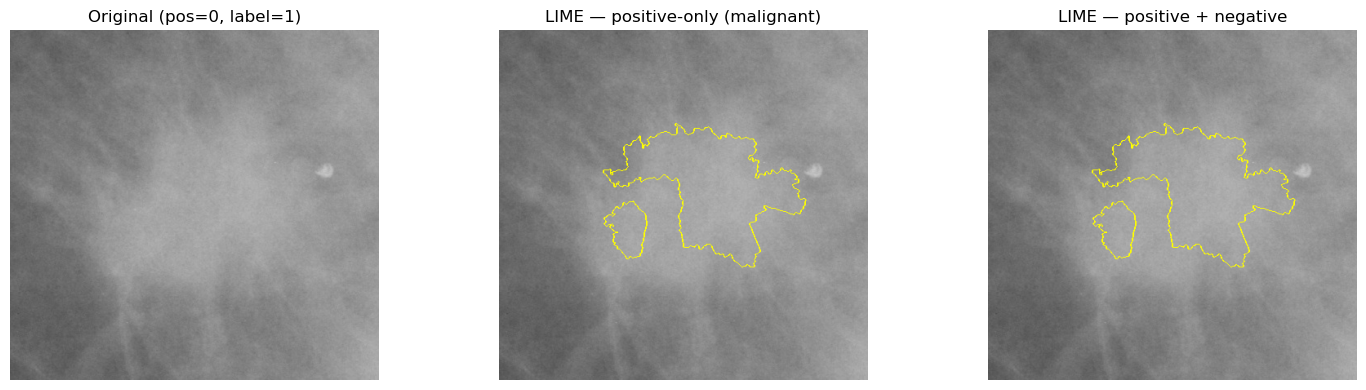

100%|██████████| 1000/1000 [00:31<00:00, 32.18it/s]


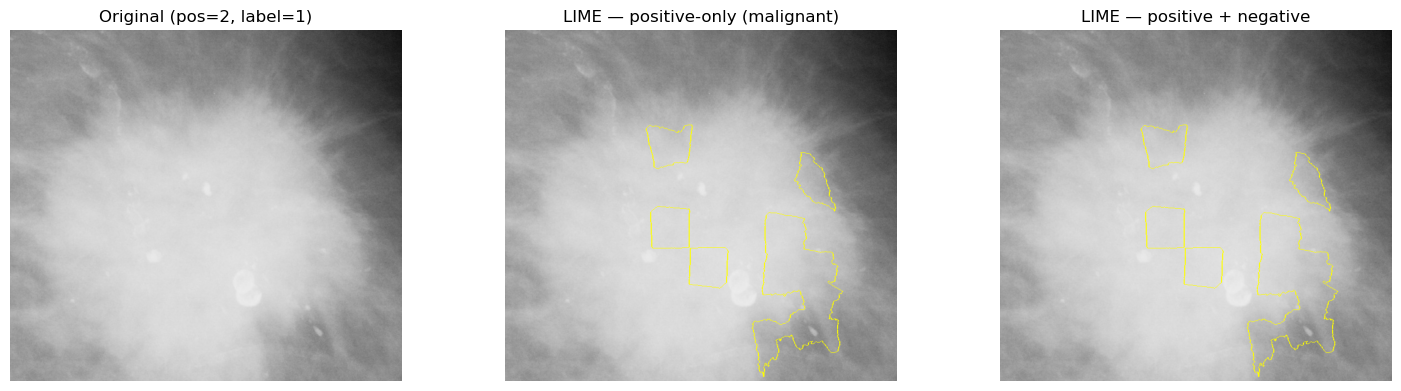

In [12]:
# %%
# ===========================================
# Cell 12 — LIME Image Explanations (2 samples) — improved visibility
# ===========================================
from skimage.segmentation import slic, mark_boundaries
from lime import lime_image

explainer_lime = lime_image.LimeImageExplainer()

for pos in chosen_pos:  # use POSITIONS, not labels
    raw, row = load_raw_rgb_from_idx(pos)
    predict_fn = make_lime_predict_fn(row, model_best)

    explanation = explainer_lime.explain_instance(
        raw,
        predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=1000,
        segmentation_fn=lambda x: slic(x, n_segments=100, compactness=10, sigma=1)
    )

    # Positive-only (malignant-supporting regions)
    _, mask_pos = explanation.get_image_and_mask(
        label=1, positive_only=True, num_features=10, hide_rest=False
    )
    # Positive + negative (also shows benign-supporting regions)
    _, mask_both = explanation.get_image_and_mask(
        label=1, positive_only=False, num_features=10, hide_rest=False
    )

    img01 = raw.astype(np.float32) / 255.0  # mark_boundaries expects [0,1]

    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.title(f"Original (pos={int(pos)}, label={int(row['label'])})")
    plt.imshow(raw); plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("LIME — positive-only (malignant)")
    plt.imshow(mark_boundaries(img01, mask_pos)); plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("LIME — positive + negative")
    plt.imshow(mark_boundaries(img01, mask_both)); plt.axis("off")

    plt.tight_layout(); plt.show()


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


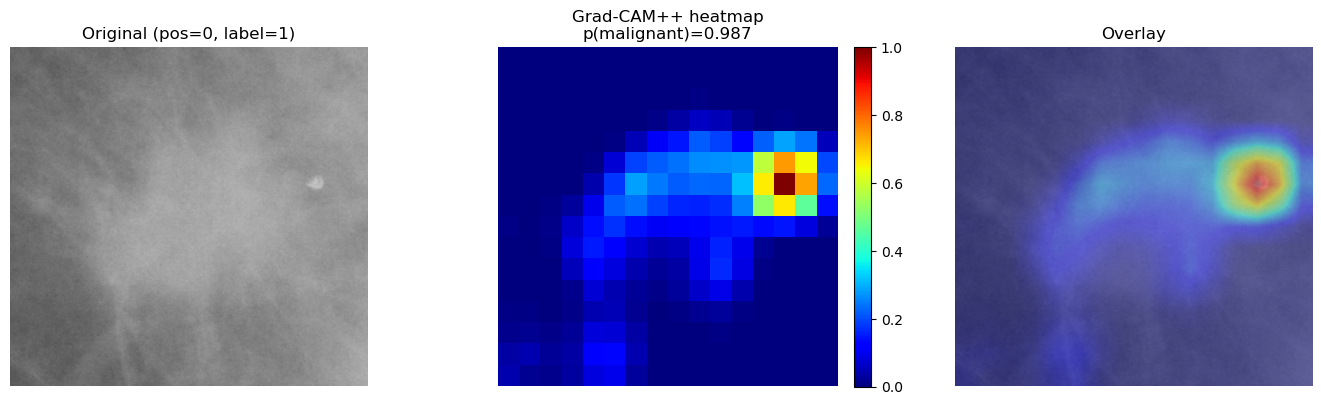

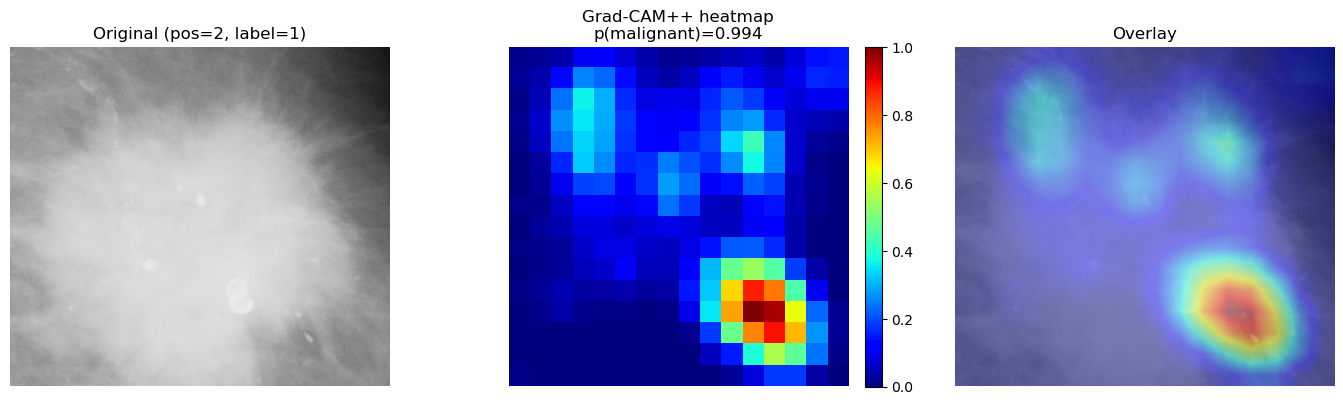

Grad-CAM++ target layer used: bn2


In [13]:
# %%
# ===========================================
# Cell 13 — Grad-CAM++ (for EffNetV2B3WithMeta + metadata)
# ===========================================
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# ---- pick a good target layer in timm EfficientNetV2 ----
def get_target_layer(model_base):
    """
    Try common last-conv activations for tf_efficientnetv2_b3.
    Prefers 'act2' (after conv_head+bn2), then 'bn2', then 'conv_head'.
    """
    names = ["act2", "bn2", "conv_head"]
    named = dict([*model_base.named_modules()])
    for n in names:
        if n in named:
            return n, named[n]
    # as a very last resort, take the last module
    last_name, last_mod = list(model_base.named_modules())[-1]
    return last_name, last_mod

class GradCAMPP:
    """
    Grad-CAM++ for binary classifier that returns a single logit.
    Works with your (x, meta) forward by wrapping meta as a fixed tensor.
    """
    def __init__(self, model_with_meta, meta_tensor_fixed, target_layer_name=None):
        """
        model_with_meta: your EffNetV2B3WithMeta model (logit output).
        meta_tensor_fixed: (1,4) tensor with laterality/view for the current sample.
        target_layer_name: str or None; if None we auto-pick.
        """
        self.model = model_with_meta.eval()
        self.meta = meta_tensor_fixed  # (1,4) on DEVICE
        # find / register target layer
        if target_layer_name is None:
            self.tgt_name, self.tgt_layer = get_target_layer(self.model.base)
        else:
            self.tgt_name = target_layer_name
            self.tgt_layer = dict([*self.model.base.named_modules()])[target_layer_name]

        self.activations = None
        self.gradients = None

        def f_hook(m, inp, out):
            self.activations = out.detach()             # (B, C, H, W)

        def b_hook(m, gin, gout):
            self.gradients = gout[0].detach()           # (B, C, H, W)

        self.tgt_layer.register_forward_hook(f_hook)
        self.tgt_layer.register_full_backward_hook(b_hook)

    def forward_logit(self, x):
        # forward producing raw logit (no sigmoid)
        return self.model(x, self.meta.expand(x.size(0), -1))

    def __call__(self, x):
        """
        x: (1,3,H,W) normalized tensor on DEVICE
        returns: cam (H, W) in [0,1]
        """
        # forward -> get logit
        logit = self.forward_logit(x)                   # (1,1)
        self.model.zero_grad()
        # backward on the positive class logit
        logit[0,0].backward(retain_graph=True)

        A = self.activations            # (1, C, H, W)
        dY = self.gradients             # (1, C, H, W)
        # Grad-CAM++ weights
        dY2 = dY ** 2
        dY3 = dY ** 3
        sumA = torch.sum(A, dim=(2,3), keepdim=True)            # (1,C,1,1)
        eps = 1e-8
        alpha = dY2 / (2.0 * dY2 + sumA * dY3 + eps)            # (1,C,H,W)
        # positive gradients only
        weights = torch.sum(alpha * F.relu(dY), dim=(2,3))      # (1,C)

        # linear combination of feature maps
        cam = torch.sum(weights[:, :, None, None] * A, dim=1)   # (1,H,W)
        cam = F.relu(cam)
        # normalize to [0,1]
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        return cam[0].detach().cpu().numpy(), float(torch.sigmoid(logit)[0,0].item())

def overlay_cam_on_image(raw_uint8, cam_01, alpha=0.4, cmap_name="jet"):
    """
    raw_uint8: (H,W,3) uint8 image
    cam_01: (H,W) in [0,1]
    returns RGB float image in [0,1]
    """
    h, w = raw_uint8.shape[:2]
    cam_resized = cam_01
    if cam_01.shape[:2] != (h, w):
        cam_resized = cv2.resize(cam_01, (w, h))
    heatmap = cm.get_cmap(cmap_name)(cam_resized)[..., :3]  # RGB [0,1]
    img = raw_uint8.astype(np.float32) / 255.0
    overlay = (1 - alpha) * img + alpha * heatmap
    return np.clip(overlay, 0, 1)

# ---- Run on the same two validation positions we used for LIME ----
for pos in chosen_pos:
    raw, row = load_raw_rgb_from_idx(pos)                      # uint8 HxWx3
    x = preprocess_to_tensor(raw).unsqueeze(0).to(DEVICE)      # (1,3,H,W)
    meta_fixed = meta_from_row(row).to(DEVICE).unsqueeze(0)    # (1,4)

    campp = GradCAMPP(model_best, meta_fixed, target_layer_name=None)
    cam, p_malignant = campp(x)

    overlay = overlay_cam_on_image(raw, cam, alpha=0.45, cmap_name="jet")

    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.title(f"Original (pos={int(pos)}, label={int(row['label'])})")
    plt.imshow(raw); plt.axis("off")

    plt.subplot(1,3,2)
    plt.title(f"Grad-CAM++ heatmap\np(malignant)={p_malignant:.3f}")
    plt.imshow(cam, cmap="jet"); plt.colorbar(fraction=0.046, pad=0.04); plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(overlay); plt.axis("off")
    plt.tight_layout(); plt.show()

print("Grad-CAM++ target layer used:", campp.tgt_name)
